# Testing a Black Box: Detecting Bias in a Medical Risk Score Algorithm
---

ML Failures lab: Dissecting Racial Bias in a Medical Risk Score by Nick Merrill, Inderpal Kaur, Samuel Greenberg is licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0).

This lab is based off of [Dissecting racial bias in an algorithm used to manage the health of populations](https://science.sciencemag.org/content/366/6464/447) by Ziad Obermeyer et al (2019).


# Background

To effectively manage patients, health systems often need to estimate patients' health risks. By calculating numerical "risk scores" for patients, healthcare providers can prioritize patients who are most at-risk and allocate more resources to them.

In this lab, we examine an algorithm widely-used in industry to assign medical risk scores to patients. For each patient, the algorithm uses *medical cost* (i.e., the amount a patient spends on medical care) to calculate their risk score. Some other features the model also takes in include details about the patient's medical history.

We've received some reports of concerns about racial bias in AI risk scoring systems, so want to test the AI to check for bias. However, we can't see the algorithm or data because this is a proprietary model trained on private medical information. What we can do is send inputs (hypothetical patient data) to the model and see the corresponding outputs (the hypothetical patient's risk score).

Let's see what we can uncover about this black box model just by  testing various inputs!

In [1]:
from sklearn.datasets import load_diabetes

In [ ]:
#@title Click the play button to load the input data we can use to test the AI.

%%capture
# import statements
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

#utility function
def convert_to_percentile(df, col_name):
    """
    Convert df column col_name to percentile.
    """
    return pd.qcut(df[col_name].rank(method='first'), 100, labels=range(1, 101))

# first, let's load the data we will need
# download this data at
# https://github.com/daylight-lab/mlfailures/blob/master/health-care-bias-lab.csv
!wget https://raw.githubusercontent.com/daylight-lab/mlfailures/master/health-care-bias-lab.csv
data = pd.read_csv('health-care-bias-lab.csv')

#add a column of risk percentiles to the dataframe called 'risk_percentile'
risk_percentile = convert_to_percentile(data, "risk_score_t")
data["risk_percentile"] = risk_percentile
data["race"] = data["race"].str.replace("black", "Black").replace("white", "White")

data_subset = data[["risk_percentile", "race", "cost_t", "gagne_sum_t"]].rename({"risk_percentile": "Risk Score",
                                                                                 "race": "Race", "cost_t": "Medical Cost",
                                                                                 "gagne_sum_t": "Illness"}, axis=1)
inputs = data_subset[["Race", "Medical Cost", "Illness"]]
outputs = data_subset[["Risk Score"]]


In [ ]:
#@title Click play to see some of the inputs and their corresponding outputs from the AI scoring system

print("The inputs we sent to the model...", "\n")
print(inputs.head(), "\n")
print("The risk score outputs we got back from the model...", "\n")
print(outputs.head())

The inputs we sent to the model... 

    Race  Medical Cost  Illness
0  White        1200.0        0
1  White        2600.0        3
2  White         500.0        0
3  White        1300.0        0
4  White        1100.0        1 

The risk score outputs we got back from the model... 

  Risk Score
0         36
1         86
2          4
3         11
4         98


## Medical cost and risk

Since the AI is using medical cost to calculate the risk scores, we expect patients with higher medical costs to have higher risk scores. If our algorithm is fair, the relationship between a patient's input cost and their output risk score shouldn't change based on the patient's race. In other words, patients with the same cost should have similar risk scores regardless of their race.

To check this relationship, we can show the input cost and the output risk on a chart like the one below.

<ipython-input-3-d412e9a7d621>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_cost = data_subset.groupby(["Risk Score", "Race"])[["Medical Cost"]].mean().reset_index()


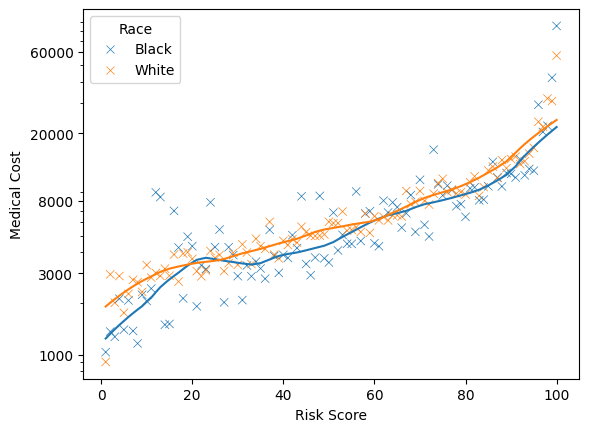

In [ ]:
#@title Click play to display a chart of the relationship between cost and risk score...
#create dataframe with the average total medical expenditure for each race at each risk percentile
group_cost = data_subset.groupby(["Risk Score", "Race"])[["Medical Cost"]].mean().reset_index()
#divide group_cost into two dataframes based on race
b_cost = group_cost[group_cost['Race'] == 'Black']
w_cost = group_cost[group_cost['Race'] == 'White']

#fit a LOWESS (Locally Weighted Scatterplot Smoothing) model to the scatterplot above for each race
risk_percentile_array_b = np.array(b_cost['Risk Score'])
risk_percentile_array_w = np.array(w_cost['Risk Score'])
b_cost_array = np.array(b_cost['Medical Cost'])
w_cost_array = np.array(w_cost['Medical Cost'])
b_cost_lowess = lowess(b_cost_array, risk_percentile_array_b, it=35, frac=0.2, delta=2)
w_cost_lowess = lowess(w_cost_array, risk_percentile_array_w, it=35, frac=0.2, delta=2)

#plot the model on the scatterplot
ax = sns.scatterplot(x = "Risk Score", y = "Medical Cost", data = group_cost, hue = "Race", marker = "x")
plt.yscale('log')
plt.plot(risk_percentile_array_b, b_cost_lowess[:, 1])
plt.plot(risk_percentile_array_w, w_cost_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

**QUESTIONS:**
1. If you were to pick a Black patient and a white patient from this dataset, both with identical medical costs, would you expect the algorithm to systematically assign a higher risk score to one or the other?
2. Can you conclude from this data alone that the model is fair or not fair?

**Answer 1**

No, with identical medical costs, the algorithm would assign similar risk scores to both patients. However, this doesn’t account for the broader bias in the cost-based proxy itself.


**Answer 2**

No, fairness cannot be concluded. The reliance on costs introduces bias against Black patients, but the model’s fairness depends on whether it achieves its intended purpose without reinforcing disparities.

## Chronic illness and risk

The purpose of the risk score is to identify patients who will likely need high-risk care or have more illnesses that require medical attention. This means that patients with more illnesses should have higher risk scores.

Again, we want to make sure that patients with the same level of illness get the same risk scores regardless of race. Let's make another plot like the one above to show these relationships.



<ipython-input-4-ac8e00964a47>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_race = data_subset.groupby(["Risk Score", "Race"])[["Illness"]].mean().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


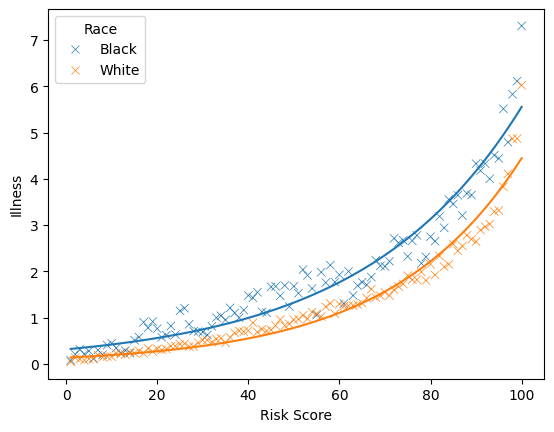

In [ ]:
#@title Click play to display a chart of the relationship between number of chronic illnesses and risk score...
# create dataframe with the average number of chronic illnesses for each race at each risk percentile
group_race = data_subset.groupby(["Risk Score", "Race"])[["Illness"]].mean().reset_index()

# divide the grouped dataframe into two dataframes based on race
b_illness = group_race[group_race['Race'] == 'Black']
w_illness = group_race[group_race['Race'] == 'White']

#fit a Generalized Linear Model (GLM) to the scatterplot above for each race
X_b = sm.add_constant(np.array(b_illness["Risk Score"]))
model_b = sm.GLM(b_illness["Illness"], X_b, family=sm.families.Gaussian(link=sm.families.links.log()))
model_b_results = model_b.fit()

X_w = sm.add_constant(np.array(w_illness["Risk Score"]))
model_w = sm.GLM(w_illness["Illness"], X_w, family=sm.families.Gaussian(link=sm.families.links.log()))
model_w_results = model_w.fit()

# plot the model on the scatterplot
sns.scatterplot(x="Risk Score", y="Illness", data=group_race, hue="Race", marker="x")
plt.plot(np.array(b_illness["Risk Score"]), model_b_results.predict())
plt.plot(np.array(w_illness["Risk Score"]), model_w_results.predict());

**QUESTIONS:**
1. If you were to pick a Black patient and a white patient from this dataset, both with identical number of chronic illnesses, would you expect the algorithm to systematically assign a higher risk score to one or the other?
2. Can you conclude from this data alone that the model is fair or not fair?

**Answer 1**

No, the algorithm would likely assign a lower risk score to the Black patient because it relies on medical costs, which are systematically lower for Black patients.

**Answer 2**

you can argue for it, But i would say no, because fairness cannot be concluded from this data alone. While the model shows evidence of bias a deeper analysis of its real-world impact and adjustments to address the bias are needed.


## What went wrong?

The charts above show us that a Black patient and a White patient who have the same medical cost will get similar risk scores from the AI system. However, a Black patient and a White patient who have the same number of illnesses can get very different risk scores. Specifically, the Black patient will be predicted to have a lower risk score than the white patient.

Imagine: a Black patient and a white patient walk into the same hospital at the same time. Their medical records are identical. The algorithm would recommend that the white patient be triaged before the Black patient!

How did this happen?

To get to the bottom of this effect, let's look at the relationship between medical cost and number of illness, by race.

<ipython-input-5-157a2a06df1b>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  illnesses = data_subset.groupby(['Illness (%-tile)', "Race"])[["Medical Cost"]].mean().reset_index()


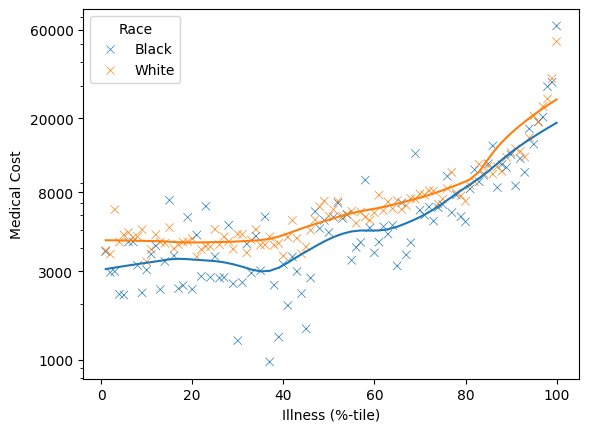

In [ ]:
#@title Click play to display a chart of the relationship between number of chronic illnesses and medical cost...
#add a column of illness percentiles to the dataframe called 'illness_percentile'
illness_percentile = convert_to_percentile(data_subset, "Illness")
data_subset['Illness (%-tile)'] = illness_percentile
#create dataframe with the average total medical expenditure for each race at each illness percentile
illnesses = data_subset.groupby(['Illness (%-tile)', "Race"])[["Medical Cost"]].mean().reset_index()

#divide illnesses into two dataframes based on race
illness_b = illnesses[illnesses['Race'] == 'Black']
illness_w = illnesses[illnesses['Race'] == 'White']

#fit a LOWESS (Locally Weighted Scatterplot Smoothing) model to the scatterplot above for each race
illness_percentile_array_b = np.array(illness_b['Illness (%-tile)'])
illness_percentile_array_w = np.array(illness_w['Illness (%-tile)'])
illness_cost_b = np.array(illness_b['Medical Cost'])
illness_cost_w = np.array(illness_w['Medical Cost'])
b_illness_lowess = lowess(illness_cost_b, illness_percentile_array_b, it=35, frac=0.3, delta=2)
w_illness_lowess = lowess(illness_cost_w, illness_percentile_array_w, it=35, frac=0.3, delta=2)

#plot the model on the scatterplot
ax = sns.scatterplot(x = "Illness (%-tile)", y = "Medical Cost", data = illnesses, hue = "Race", marker = "x")
plt.yscale('log')
plt.plot(illness_percentile_array_b, b_illness_lowess[:, 1])
plt.plot(illness_percentile_array_w, w_illness_lowess[:, 1])
ax.set_yticks([1000, 3000, 8000, 20000, 60000])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter());

**Questions:**
1. If you were to pick a Black patient and a white patient from this dataset, both with an identical number of chronic illnesses, would you expect either patient to systematically spend more on their health care costs?
2. How did this discrepancy caused the algorithm to underestimate the medical risk to Black patients?
3. Why might we observe this discrepancy?


**Answer 1**

Yes, the White patient would systematically spend more. This reflects systemic barriers like limited access to healthcare, socioeconomic disadvantages, and historical discrimination that lead to reduced spending by Black patients.


**Answer 2**

The algorithm assumes higher medical costs indicate higher risk. Since Black patients spend less due to systemic inequities, the algorithm underestimates their medical risk.

**Answer 3**

Access Barriers: Transportation issues, childcare responsibilities, and income disparities disproportionately affect Black patients' ability to access care.

Discrimination: Implicit bias in the healthcare system impacts the care Black patients receive.

Trust: Historical events like the Tuskegee study have reduced trust in the healthcare system among Black patients.


## Conclusions and takeaways

The AI system used to calculate patient risk scores might be a black box, but we were still able to find evidence of bias in the model by testing it with different inputs and displaying the relationship with the output.

The takeaway here is clear: we can identify bias in black-box models---*as long as we have access to the sensitive features.*

When we drilled down into this bias, we discovered a cause: given a Black patient and a white patient with the same number of chronic illnesses, the white patient will spend more on their health care. But why? Obermeyer et al. opined in the Nature paper on which this lab is based:

>The literature broadly suggests two main potential channels. First, poor patients face substantial barriers to accessing health care, even when enrolled in insurance plans. Although the population we study is entirely insured, there are many other mechanisms by which poverty can lead to disparities in use of health care: geography and differential access to transportation, competing demands from jobs or child care, or knowledge of reasons to seek care (1-3). To the extent that race and socioeconomic status are correlated, these factors will differentially affect Black patients. Second, race could affect costs directly via several channels: direct (“taste-based”) discrimination, changes to the doctor–patient relationship, or others. A recent trial randomly assigned Black patients to a Black or White primary care provider and found significantly higher uptake of recommended preventive care when the provider was Black (4). This is perhaps the most rigorous demonstration of this effect, and it fits with a larger literature on potential mechanisms by which race can affect health care directly. For example, it has long been documented that Black patients have reduced trust in the health care system (5), a fact that some studies trace to the revelations of the Tuskegee study and other adverse experiences (6). A substantial literature in psychology has documented physicians’ differential perceptions of Black patients, in terms of intelligence, affiliation (7), or pain tolerance (8). **Thus, whether it is communication, trust, or bias, something about the interactions of Black patients with the health care system itself leads to reduced use of health care. The collective effect of these many channels is to lower health spending substantially for Black patients, conditional on need—a finding that has been appreciated for at least two decades (9).**

## Reflection Questions

Here is a final open-ended question for you to answer.

1. How could we use the data we have to create new proxies for health needs that may be less biased than medical costs?

**Answer**

1) Instead of metrics like **cost** use metrics like **the number of chronic illnesses**

2) consider **preventive care usage**

3) Evalaute **health outcome ** (recovery rate etc.)

4) Introduce patient-reported metrics like quality of life or symptom severity. These approaches focus on medical needs instead of financial measures that are heavily influenced by systemic inequities.

## References

1. K. Fiscella, P. Franks, M. R. Gold, C. M. Clancy, JAMA 283, 2579–2584 (2000).
2. N. E. Adler, K. Newman, Health Aff. 21, 60–76 (2002).
3. N. E. Adler, W. T. Boyce, M. A. Chesney, S. Folkman, S. L. Syme, JAMA 269, 3140–3145 (1993).
4. M. Alsan, O. Garrick, G. C. Graziani, “Does diversity matter for health? Experimental evidence from Oakland” (National Bureau of Economic Research, 2018).
5. K. Armstrong, K. L. Ravenell, S. McMurphy, M. Putt, Am. J. Public Health 97, 1283–1289 (2007).
6. M. Alsan, M. Wanamaker, Q. J. Econ. 133, 407–455 (2018).
7. M. van Ryn, J. Burke, Soc. Sci. Med. 50, 813–828 (2000).
8. K. M. Hoffman, S. Trawalter, J. R. Axt, M. N. Oliver, Proc. Natl. Acad. Sci. U.S.A. 113, 4296–4301 (2016).
9. J. J. Escarce, F. W. Puffer, in Racial and Ethnic Differences in the Health of Older Americans (National Academies Press, 1997), chap. 6; www.ncbi.nlm.nih.gov/books/ NBK109841/.

# Feedback

**Instructors**: Please [provide feedback](https://docs.google.com/forms/d/1UuUVBBMTU_2aMvzsGnTR_4i1w3F6tLaaqdIr7dQrgSI/edit?ts=5efa771b&dods) to help improve this lab.

**Students**: Please [provide feedback](https://docs.google.com/forms/d/1jI8oXRkqD1l1ARuZR1y9W_qkOystPr-YEyywNDez46M/edit?ts=5efa772a&dods) to help improve this lab.
